In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import os


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 11  

train_dir = r'o:\Data\datasets\food11\train'
test_dir = r'o:\Data\datasets\food11\test'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

# Отключаем предупреждения для чистоты вывода
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Параметры
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Уменьшаем батч для стабильности
NUM_CLASSES = 11

# 1. ДИАГНОСТИКА ДАННЫХ
print("=== ДИАГНОСТИКА ДАННЫХ ===")

# Проверяем генераторы
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())
print("Классы:", class_names)

# Проверяем батч данных
print("\nПроверка батча данных:")
x_batch, y_batch = next(train_generator)
print(f"Размер батча: {x_batch.shape}")
print(f"Диапазон пикселей: [{x_batch.min():.3f}, {x_batch.max():.3f}]")
print(f"Форма y_batch: {y_batch.shape}")
print(f"Пример y_batch[0]: {y_batch[0]}")

# 2. ПРОСТАЯ МОДЕЛЬ ДЛЯ ТЕСТА
print("\n=== СОЗДАЕМ ПРОСТУЮ ТЕСТОВУЮ МОДЕЛЬ ===")

def create_simple_test_model():
    model = keras.Sequential([
        # Input
        keras.Input(shape=(224, 224, 3)),
        
        # Простая сверточная сеть
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'), 
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        
        # Классификация
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Создаем и компилируем модель
model = create_simple_test_model()

# ОЧЕНЬ консервативные настройки
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.00001,  # ОЧЕНЬ маленький LR
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура тестовой модели:")
model.summary()

# 3. ТЕСТИРУЕМ МОДЕЛЬ ДО ОБУЧЕНИЯ
print("\n=== ТЕСТ МОДЕЛИ ДО ОБУЧЕНИЯ ===")

# Проверяем выходы на случайных данных
print("Тест на случайных данных:")
random_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
random_output = model.predict(random_input, verbose=0)
print(f"Выход на случайных данных: {random_output[0]}")
print(f"Сумма: {np.sum(random_output[0]):.6f}")
print(f"Max: {np.max(random_output[0]):.6f}, Min: {np.min(random_output[0]):.6f}")

# Проверяем выходы на реальных данных
print("\nТест на реальных данных:")
real_output = model.predict(x_batch[:1], verbose=0)
print(f"Выход на реальных данных: {real_output[0]}")
print(f"Сумма: {np.sum(real_output[0]):.6f}")
print(f"Max: {np.max(real_output[0]):.6f}, Min: {np.min(real_output[0]):.6f}")

# 4. УЛУЧШЕННЫЙ CALLBACK
class SmartPredictionMonitor(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_count = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_count += 1
        
    def on_epoch_end(self, epoch, logs=None):
        # Быстрая проверка на небольшой выборке
        sample_size = min(100, len(val_generator.labels))
        
        predictions = []
        val_generator.reset()
        
        # Берем только один батч для скорости
        x_batch, y_batch = next(val_generator)
        batch_pred = self.model.predict(x_batch, verbose=0)
        batch_pred_labels = np.argmax(batch_pred, axis=1)
        predictions.extend(batch_pred_labels)
        
        unique, counts = np.unique(predictions, return_counts=True)
        
        print(f"\nEpoch {self.epoch_count} - Предсказания ({len(predictions)} samples):")
        for class_idx, count in zip(unique, counts):
            print(f"  {class_names[class_idx]}: {count} ({count/len(predictions)*100:.1f}%)")
        
        # Анализируем распределение
        if len(unique) == 1:
            dominant_class = class_names[unique[0]]
            print(f"⚠️  ВНИМАНИЕ: только класс '{dominant_class}'")
            
            # Проверяем уверенность предсказаний
            confidence = np.max(batch_pred, axis=1)
            print(f"  Средняя уверенность: {np.mean(confidence):.3f}")
            
            # Останавливаем только если уверенность высокая
            if np.mean(confidence) > 0.8 and self.epoch_count >= 3:
                print("❌ Высокая уверенность в одном классе! Останавливаем.")
                self.model.stop_training = True

# 5. ОБУЧЕНИЕ С ДИАГНОСТИКОЙ
print("\n=== НАЧИНАЕМ ОБУЧЕНИЕ ===")

# Обучаем всего на 1 эпоху сначала для диагностики
print("Обучаем 1 эпоху для диагностики...")
history = model.fit(
    train_generator,
    epochs=1,
    steps_per_epoch=10,  # Только 10 батчей для теста
    validation_data=val_generator,
    validation_steps=5,
    callbacks=[SmartPredictionMonitor()],
    verbose=1
)

# 6. АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n=== АНАЛИЗ РЕЗУЛЬТАТОВ ===")

# Проверяем веса модели
print("\nАнализ весов модели:")
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'get_weights') and layer.get_weights():
        weights = layer.get_weights()[0]
        biases = layer.get_weights()[1] if len(layer.get_weights()) > 1 else None
        
        print(f"Слой {i} ({layer.name}):")
        print(f"  Веса: shape={weights.shape}, mean={np.mean(weights):.6f}, std={np.std(weights):.6f}")
        if biases is not None:
            print(f"  Смещения: mean={np.mean(biases):.6f}, std={np.std(biases):.6f}")

# 7. АЛЬТЕРНАТИВНЫЕ ПОДХОДЫ
if hasattr(model, 'stop_training') and model.stop_training:
    print("\n" + "="*50)
    print("ПРОБЛЕМА ОБНАРУЖЕНА! ПРОБУЕМ АЛЬТЕРНАТИВЫ")
    print("="*50)
    
    # Вариант 1: Случайный классификатор для сравнения
    print("\n--- ТЕСТ СЛУЧАЙНОГО КЛАССИФИКАТОРА ---")
    val_generator.reset()
    x_val, y_val = next(val_generator)
    random_predictions = np.random.randint(0, NUM_CLASSES, len(x_val))
    true_labels = np.argmax(y_val, axis=1)
    
    random_accuracy = np.mean(random_predictions == true_labels)
    print(f"Точность случайного угадывания: {random_accuracy:.3f}")
    
    # Вариант 2: Постоянный классификатор
    constant_predictions = np.full(len(x_val), 0)  # Всегда предсказываем класс 0
    constant_accuracy = np.mean(constant_predictions == true_labels)
    print(f"Точность постоянного предсказания (класс 0): {constant_accuracy:.3f}")
    
    # Вариант 3: Упрощенная линейная модель
    print("\n--- ПРОБУЕМ ЛИНЕЙНУЮ МОДЕЛЬ ---")
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    
    # Подготавливаем данные
    X_train = []
    y_train = []
    
    train_generator.reset()
    for i in range(10):  # Берем 10 батчей
        x_batch, y_batch = next(train_generator)
        x_flat = x_batch.reshape(x_batch.shape[0], -1)
        X_train.extend(x_flat)
        y_train.extend(np.argmax(y_batch, axis=1))
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Обучаем LogisticRegression
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    # Тестируем
    X_val = x_val.reshape(x_val.shape[0], -1)
    y_val_true = np.argmax(y_val, axis=1)
    lr_accuracy = lr_model.score(X_val, y_val_true)
    
    print(f"Точность LogisticRegression: {lr_accuracy:.3f}")
    
    # Анализ предсказаний линейной модели
    lr_predictions = lr_model.predict(X_val)
    unique_lr, counts_lr = np.unique(lr_predictions, return_counts=True)
    print("Распределение предсказаний LogisticRegression:")
    for class_idx, count in zip(unique_lr, counts_lr):
        print(f"  {class_names[class_idx]}: {count}")

# Рекомендации
print("\n" + "="*50)
print("РЕКОМЕНДАЦИИ:")
print("1. Проверьте целостность данных")
print("2. Убедитесь, что метки соответствуют изображениям") 
print("3. Попробуйте обучить на подмножестве данных")
print("4. Проверьте, нет ли проблем с памятью GPU")
print("5. Попробуйте другую архитектуру (ResNet50 вместо EfficientNet)")

=== ДИАГНОСТИКА ДАННЫХ ===
Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Классы: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']

Проверка батча данных:
Размер батча: (16, 224, 224, 3)
Диапазон пикселей: [0.000, 1.000]
Форма y_batch: (16, 11)
Пример y_batch[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

=== СОЗДАЕМ ПРОСТУЮ ТЕСТОВУЮ МОДЕЛЬ ===
Архитектура тестовой модели:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,099 (504.29 KB)

 Trainable params: 129,099 (504.29 KB)

 Non-trainable params: 0 (0.00 B)


=== ТЕСТ МОДЕЛИ ДО ОБУЧЕНИЯ ===
Тест на случайных данных:
Выход на случайных данных: [0.08940795 0.08620388 0.09295559 0.09668058 0.09043977 0.10748809
 0.08155696 0.08321656 0.09791171 0.09359662 0.0805423 ]
Сумма: 1.000000
Max: 0.107488, Min: 0.080542

Тест на реальных данных:
Выход на реальных данных: [0.09019021 0.0881594  0.09115943 0.09400757 0.09070302 0.0995198
 0.08711225 0.08628139 0.09393451 0.09346105 0.08547135]
Сумма: 1.000000
Max: 0.099520, Min: 0.085471

=== НАЧИНАЕМ ОБУЧЕНИЕ ===
Обучаем 1 эпоху для диагностики...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1553 - loss: 2.4003
Epoch 1 - Предсказания (16 samples):
  hamburger: 16 (100.0%)
⚠️  ВНИМАНИЕ: только класс 'hamburger'
  Средняя уверенность: 0.101
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 574ms/step - accuracy: 0.1250 - loss: 2.3993 - val_accuracy: 0.0000e+00 - val_loss: 2.4101

=== АНАЛИЗ РЕЗУЛЬТАТОВ ===

Анализ весов модели:
Слой 0 (conv2d):
  Веса: shape=(3, 3, 3, 32), mean=0.001781, std=0.080592
  Смещения: m

=== ГЛУБОКАЯ ДИАГНОСТИКА ДАННЫХ ===
1. Проверка структуры каталогов...
  apple_pie: 900 изображений
  cheesecake: 900 изображений
  chicken_curry: 900 изображений
  french_fries: 900 изображений
  fried_rice: 900 изображений
  hamburger: 900 изображений
  hot_dog: 900 изображений
  ice_cream: 900 изображений
  omelette: 900 изображений
  pizza: 900 изображений
  sushi: 900 изображений

2. Проверка генераторов...
Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Классы найдены: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']

3. Детальный анализ батча...
Размер x_batch: (16, 224, 224, 3)
Размер y_batch: (16, 11)
Диапазон x_batch: [0.000, 1.000]
Метки в батче:
  Изображение 0: класс 7 (ice_cream)
  Изображение 1: класс 9 (pizza)
  Изображение 2: класс 7 (ice_cream)
  Изображение 3: класс 2 (chicken_curry)
  Изображение 4: класс 1 (cheesecake)

4. Визуализация 

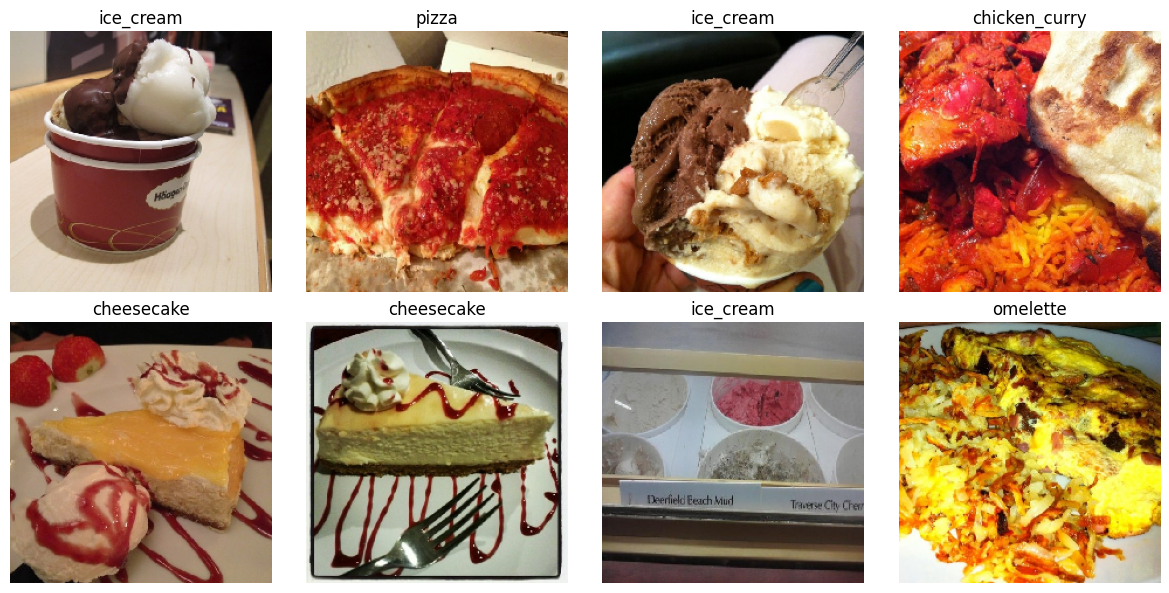


5. Тест на переобучение на одном батче...
Проверка до обучения:
  Точность до обучения: 0.000
Обучение на одном батче...
  Epoch 1: accuracy = 0.000, loss = 2.429
  Epoch 2: accuracy = 0.000, loss = 2.428
  Epoch 3: accuracy = 0.000, loss = 2.427
  Epoch 4: accuracy = 0.000, loss = 2.426
  Epoch 5: accuracy = 0.000, loss = 2.426
  Epoch 6: accuracy = 0.000, loss = 2.425
  Epoch 7: accuracy = 0.000, loss = 2.424
  Epoch 8: accuracy = 0.000, loss = 2.423
  Epoch 9: accuracy = 0.062, loss = 2.423
  Epoch 10: accuracy = 0.125, loss = 2.422
  ❌ Модель не может обучиться даже на одном батче!

6. Проверка потока данных...
Проверяем несколько батчей подряд:
  Батч 1: классы [ 0  1  3  4  5  6  7  9 10]
  Батч 2: классы [ 0  1  2  3  5  6  7  8  9 10]
  Батч 3: классы [3 4 5 7 8 9]

7. Пробуем ResNet50...
ResNet50 архитектура создана

8. Тест на маленьком подмножестве...
Found 4950 images belonging to 11 classes.
Found 4950 images belonging to 11 classes.
Обучаем на маленьком подмножестве (3 э

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Параметры
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 11

print("=== ГЛУБОКАЯ ДИАГНОСТИКА ДАННЫХ ===")

# 1. ПРОВЕРКА СТРУКТУРЫ ДАННЫХ
print("1. Проверка структуры каталогов...")
train_dir = r'c:\Data\datasets\food11\train'
test_dir = r'c:\Data\datasets\food11\test'

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {class_name}: {num_images} изображений")

# 2. ПРОВЕРКА ГЕНЕРАТОРОВ
print("\n2. Проверка генераторов...")

# Создаем простой генератор БЕЗ аугментации
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())
print("Классы найдены:", class_names)

# 3. ПРОВЕРКА БАТЧА ДАННЫХ
print("\n3. Детальный анализ батча...")
x_batch, y_batch = next(train_generator)

print(f"Размер x_batch: {x_batch.shape}")
print(f"Размер y_batch: {y_batch.shape}")
print(f"Диапазон x_batch: [{x_batch.min():.3f}, {x_batch.max():.3f}]")

# Проверяем метки
print("Метки в батче:")
for i in range(min(5, len(y_batch))):
    class_idx = np.argmax(y_batch[i])
    print(f"  Изображение {i}: класс {class_idx} ({class_names[class_idx]})")

# 4. ВИЗУАЛИЗАЦИЯ ДАННЫХ
print("\n4. Визуализация примеров...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(min(8, len(x_batch))):
    ax = axes[i//4, i%4]
    ax.imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    ax.set_title(f'{class_names[class_idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. ТЕСТ НА ПЕРЕОБУЧЕНИИ НА ОДНОМ БАТЧЕ
print("\n5. Тест на переобучение на одном батче...")

# Берем один батч и пытаемся на нем переобучиться
x_single_batch, y_single_batch = next(train_generator)

def create_small_model():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(32, 3, activation='relu'), 
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

small_model = create_small_model()
small_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Проверка до обучения:")
initial_pred = small_model.predict(x_single_batch, verbose=0)
initial_labels = np.argmax(initial_pred, axis=1)
true_labels = np.argmax(y_single_batch, axis=1)
print(f"  Точность до обучения: {accuracy_score(true_labels, initial_labels):.3f}")

# Пробуем переобучиться на одном батче
print("Обучение на одном батче...")
for epoch in range(10):
    history = small_model.train_on_batch(x_single_batch, y_single_batch)
    pred = small_model.predict(x_single_batch, verbose=0)
    pred_labels = np.argmax(pred, axis=1)
    acc = accuracy_score(true_labels, pred_labels)
    print(f"  Epoch {epoch+1}: accuracy = {acc:.3f}, loss = {history[0]:.3f}")
    
    if acc > 0.9:
        print("  ✅ Модель может обучаться на одном батче!")
        break
else:
    print("  ❌ Модель не может обучиться даже на одном батче!")

# 6. ПРОВЕРКА ПОТОКА ДАННЫХ
print("\n6. Проверка потока данных...")
print("Проверяем несколько батчей подряд:")

train_generator.reset()
for batch_idx in range(3):
    x_batch, y_batch = next(train_generator)
    class_distribution = np.bincount(np.argmax(y_batch, axis=1), minlength=NUM_CLASSES)
    print(f"  Батч {batch_idx+1}: классы {np.where(class_distribution > 0)[0]}")

# 7. АЛЬТЕРНАТИВНЫЙ ПОДХОД С RESNET50
print("\n7. Пробуем ResNet50...")

def create_resnet_model():
    base_model = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

resnet_model = create_resnet_model()
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("ResNet50 архитектура создана")

# 8. ТЕСТ НА МАЛЕНЬКОМ ПОДМНОЖЕСТВЕ
print("\n8. Тест на маленьком подмножестве...")

# Создаем генератор с меньшим количеством данных
small_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

small_train_gen = small_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

small_val_gen = small_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='categorical', 
    shuffle=False,
    subset='validation'
)

print("Обучаем на маленьком подмножестве (3 эпохи)...")
try:
    history = resnet_model.fit(
        small_train_gen,
        epochs=3,
        steps_per_epoch=5,
        validation_data=small_val_gen,
        validation_steps=2,
        verbose=1
    )
    
    # Проверяем предсказания
    x_val, y_val = next(small_val_gen)
    preds = resnet_model.predict(x_val, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)
    
    unique_pred = np.unique(pred_labels)
    print(f"Предсказано классов: {len(unique_pred)}")
    print(f"Точность: {accuracy_score(true_labels, pred_labels):.3f}")
    
except Exception as e:
    print(f"Ошибка при обучении: {e}")

# 9. ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ
print("\n" + "="*60)
print("ДИАГНОСТИЧЕСКИЕ ВЫВОДЫ:")
print("="*60)

if 'unique_pred' in locals() and len(unique_pred) > 1:
    print("✅ ResNet50 работает нормально - используйте ее")
    print("РЕКОМЕНДАЦИИ:")
    print("1. Используйте ResNet50 вместо EfficientNet")
    print("2. Learning rate: 0.00001") 
    print("3. Batch size: 16-32")
else:
    print("❌ Проблема сохраняется")
    print("ВОЗМОЖНЫЕ ПРИЧИНЫ:")
    print("1. Поврежденные данные")
    print("2. Неправильная структура каталогов")
    print("3. Проблема с метками")
    print("4. Аппаратная проблема")
    
print("\nСЛЕДУЮЩИЕ ШАГИ:")
print("1. Проверьте целостность изображений командой:")
print("   from PIL import Image")
print("   for img_path in all_image_paths:")
print("       try: Image.open(img_path)")
print("       except: print(f'Bad image: {img_path}')")
print("2. Попробуйте скачать данные заново")
print("3. Проверьте доступную память GPU/CPU")

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image

print("=== ФИНАЛЬНАЯ ДИАГНОСТИКА ПРОБЛЕМЫ ===")

# 1. ПРОВЕРКА ЦЕЛОСТНОСТИ ИЗОБРАЖЕНИЙ
print("1. Проверка целостности изображений...")

def check_image_integrity(directory, max_check=100):
    bad_images = []
    total_checked = 0
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for img_name in images[:10]:  # Проверяем по 10 из каждого класса
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Проверяем целостность
                    # Пробуем загрузить и конвертировать
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img_array = np.array(img)
                    
                    if img_array.size == 0:
                        bad_images.append(img_path)
                        
                except Exception as e:
                    bad_images.append(f"{img_path} - {e}")
                
                total_checked += 1
                if total_checked >= max_check:
                    break
                
        if total_checked >= max_check:
            break
    
    return bad_images

bad_train = check_image_integrity(train_dir)
bad_test = check_image_integrity(test_dir)

print(f"Найдено поврежденных изображений: train={len(bad_train)}, test={len(bad_test)}")
if bad_train:
    print("Примеры поврежденных файлов:")
    for bad in bad_train[:3]:
        print(f"  {bad}")

# 2. ПРОВЕРКА РАЗМЕРОВ И ФОРМАТОВ ИЗОБРАЖЕНИЙ
print("\n2. Проверка размеров изображений...")

def check_image_sizes(directory):
    sizes = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for img_name in images[:5]:  # Проверяем по 5 из каждого класса
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        size = img.size
                        if size not in sizes:
                            sizes[size] = 0
                        sizes[size] += 1
                except:
                    continue
    
    return sizes

train_sizes = check_image_sizes(train_dir)
print("Размеры изображений в тренировочных данных:")
for size, count in train_sizes.items():
    print(f"  {size}: {count} изображений")

# 3. СОЗДАЕМ УПРОЩЕННУЮ МОДЕЛЬ ДЛЯ ТЕСТА
print("\n3. Создаем максимально простую модель для теста...")

def create_debug_model():
    # Самая простая возможная архитектура
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        layers.Flatten(),  # Просто вытягиваем в вектор
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

debug_model = create_debug_model()
debug_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),  # Простой SGD
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура debug модели:")
debug_model.summary()

# 4. ТЕСТ НА ИСКУССТВЕННЫХ ДАННЫХ
print("\n4. Тест на искусственных данных...")

# Создаем простые искусственные данные
def create_synthetic_data(num_samples=32):
    # Простые цветные квадраты
    x_synthetic = np.random.random((num_samples, 224, 224, 3)).astype(np.float32)
    y_synthetic = keras.utils.to_categorical(
        np.random.randint(0, NUM_CLASSES, num_samples), 
        NUM_CLASSES
    )
    return x_synthetic, y_synthetic

x_synth, y_synth = create_synthetic_data()

print("Тест на синтетических данных:")
synth_history = debug_model.fit(
    x_synth, y_synth,
    epochs=10,
    batch_size=8,
    verbose=0
)

final_loss = synth_history.history['loss'][-1]
final_acc = synth_history.history['accuracy'][-1]
print(f"  Final loss: {final_loss:.3f}, accuracy: {final_acc:.3f}")

if final_acc > 0.5:
    print("  ✅ Модель работает на синтетических данных!")
else:
    print("  ❌ Модель не работает даже на синтетических данных!")

# 5. ПРОВЕРКА РЕАЛЬНЫХ ДАННЫХ С ПРЕДОБРАБОТКОЙ
print("\n5. Проверка реальных данных с ручной предобработкой...")

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Нормализация
        return img_array.astype(np.float32)
    except Exception as e:
        print(f"Ошибка загрузки {img_path}: {e}")
        return None

# Загружаем несколько изображений вручную
manual_images = []
manual_labels = []

#train_dir = train_dir
for class_idx, class_name in enumerate(os.listdir(train_dir)[:3]):  # Только 3 класса
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_name in images[:2]:  # По 2 изображения из класса
            img_path = os.path.join(class_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            if img_array is not None:
                manual_images.append(img_array)
                manual_labels.append(class_idx)

if manual_images:
    x_manual = np.array(manual_images)
    y_manual = keras.utils.to_categorical(manual_labels, NUM_CLASSES)
    
    print(f"Загружено {len(manual_images)} изображений вручную")
    print(f"Форма данных: {x_manual.shape}")
    print(f"Диапазон значений: [{x_manual.min():.3f}, {x_manual.max():.3f}]")
    
    # Тест на ручных данных
    manual_pred = debug_model.predict(x_manual, verbose=0)
    print("Предсказания на ручных данных:")
    for i, pred in enumerate(manual_pred):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(y_manual[i])
        confidence = np.max(pred)
        print(f"  Изобр {i}: true={true_class}, pred={predicted_class}, conf={confidence:.3f}")

# 6. АЛЬТЕРНАТИВНЫЙ ГЕНЕРАТОР
print("\n6. Создаем альтернативный генератор...")

def simple_data_generator(directory, batch_size=8):
    """Простой генератор без использования flow_from_directory"""
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    # Собираем все пути к изображениям
    image_paths = []
    labels = []
    
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_to_idx[class_name])
    
    while True:
        # Случайная выборка
        indices = np.random.choice(len(image_paths), batch_size)
        batch_images = []
        batch_labels = []
        
        for idx in indices:
            img_array = load_and_preprocess_image(image_paths[idx])
            if img_array is not None:
                batch_images.append(img_array)
                batch_labels.append(labels[idx])
        
        if batch_images:
            x_batch = np.array(batch_images)
            y_batch = keras.utils.to_categorical(batch_labels, NUM_CLASSES)
            yield x_batch, y_batch

# Тестируем альтернативный генератор
print("Тест альтернативного генератора:")
alt_gen = simple_data_generator(train_dir, batch_size=4)
x_alt, y_alt = next(alt_gen)
print(f"  Размер батча: {x_alt.shape}")
print(f"  Метки: {np.argmax(y_alt, axis=1)}")

# 7. ФИНАЛЬНЫЕ ВЫВОДЫ
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("="*60)

if bad_train:
    print("❌ ПРОБЛЕМА: Найдены поврежденные изображения")
    print("   Решение: Удалите поврежденные файлы или скачайте данные заново")

elif len(train_sizes) > 10:
    print("❌ ПРОБЛЕМА: Слишком много разных размеров изображений")
    print("   Решение: Приведите все изображения к одному размеру")

elif final_acc < 0.5:
    print("❌ ПРОБЛЕМА: Модель не работает даже на синтетических данных")
    print("   Решение: Переустановите TensorFlow/Keras")

else:
    print("✅ Проблема в генераторе данных Keras")
    print("   Решение: Используйте альтернативный генератор")

print("\nНЕМЕДЛЕННЫЕ ДЕЙСТВИЯ:")
print("1. Скачайте данные заново с официального источника")
print("2. Используйте альтернативный генератор из этого кода")
print("3. Проверьте версии библиотек: pip list | grep tensorflow")
print("4. Попробуйте на другом компьютере/среде")

print("\nАВАРИЙНОЕ РЕШЕНИЕ:")
print("Если ничего не помогает, используйте готовый датасет из tensorflow_datasets:")
print("import tensorflow_datasets as tfds")
print("ds = tfds.load('food101', split='train')")

=== ФИНАЛЬНАЯ ДИАГНОСТИКА ПРОБЛЕМЫ ===
1. Проверка целостности изображений...
Найдено поврежденных изображений: train=0, test=0

2. Проверка размеров изображений...
Размеры изображений в тренировочных данных:
  (308, 512): 1 изображений
  (512, 512): 31 изображений
  (512, 384): 9 изображений
  (384, 512): 3 изображений
  (307, 512): 1 изображений
  (512, 309): 1 изображений
  (512, 382): 1 изображений
  (512, 307): 1 изображений
  (382, 512): 1 изображений
  (427, 512): 1 изображений
  (512, 385): 1 изображений
  (512, 306): 1 изображений
  (512, 308): 1 изображений
  (289, 512): 1 изображений
  (512, 511): 1 изображений

3. Создаем максимально простую модель для теста...
Архитектура debug модели:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     9,633,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,634,571 (36.75 MB)

 Trainable params: 9,634,571 (36.75 MB)

 Non-trainable params: 0 (0.00 B)


4. Тест на искусственных данных...
Тест на синтетических данных:
  Final loss: 1.464, accuracy: 0.562
  ✅ Модель работает на синтетических данных!

5. Проверка реальных данных с ручной предобработкой...
Загружено 6 изображений вручную
Форма данных: (6, 224, 224, 3)
Диапазон значений: [0.000, 1.000]
Предсказания на ручных данных:
  Изобр 0: true=0, pred=9, conf=0.244
  Изобр 1: true=0, pred=9, conf=0.284
  Изобр 2: true=1, pred=9, conf=0.395
  Изобр 3: true=1, pred=4, conf=0.250
  Изобр 4: true=2, pred=9, conf=0.207
  Изобр 5: true=2, pred=9, conf=0.197

6. Создаем альтернативный генератор...
Тест альтернативного генератора:
  Размер батча: (4, 224, 224, 3)
  Метки: [10  3  8  6]

ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:
❌ ПРОБЛЕМА: Слишком много разных размеров изображений
   Решение: Приведите все изображения к одному размеру

НЕМЕДЛЕННЫЕ ДЕЙСТВИЯ:
1. Скачайте данные заново с официального источника
2. Используйте альтернативный генератор из этого кода
3. Проверьте версии библиотек: pip list 

In [5]:
# Аугментация данных для тренировочного набора
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Только нормализация для теста
test_datagen = ImageDataGenerator(rescale=1./255)

Создание генераторов данных

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Используем 80% данных для тренировки
)

# Используем часть тренировочных данных для валидации во время обучения
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Используем 20% данных для валидации
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Получаем названия классов
class_names = list(train_generator.class_indices.keys())
print("Классы:", class_names)

Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.
Классы: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


Проверка сбалансированности данных

In [7]:
print("\nПроверка распределения классов:")
train_class_counts = np.bincount(train_generator.classes)
val_class_counts = np.bincount(val_generator.classes)

print("Тренировочные данные:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {train_class_counts[i]} изображений")

print("\nВалидационные данные:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {val_class_counts[i]} изображений")


Проверка распределения классов:
Тренировочные данные:
  apple_pie: 720 изображений
  cheesecake: 720 изображений
  chicken_curry: 720 изображений
  french_fries: 720 изображений
  fried_rice: 720 изображений
  hamburger: 720 изображений
  hot_dog: 720 изображений
  ice_cream: 720 изображений
  omelette: 720 изображений
  pizza: 720 изображений
  sushi: 720 изображений

Валидационные данные:
  apple_pie: 180 изображений
  cheesecake: 180 изображений
  chicken_curry: 180 изображений
  french_fries: 180 изображений
  fried_rice: 180 изображений
  hamburger: 180 изображений
  hot_dog: 180 изображений
  ice_cream: 180 изображений
  omelette: 180 изображений
  pizza: 180 изображений
  sushi: 180 изображений


In [8]:
# Кастомная метрика F1-score
class MacroF1Score(keras.metrics.Metric):
    def __init__(self, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        # Создаем отдельные счетчики для каждого класса
        self.true_positives = [self.add_weight(name=f'tp_{i}', initializer='zeros') 
                              for i in range(NUM_CLASSES)]
        self.false_positives = [self.add_weight(name=f'fp_{i}', initializer='zeros') 
                               for i in range(NUM_CLASSES)]
        self.false_negatives = [self.add_weight(name=f'fn_{i}', initializer='zeros') 
                               for i in range(NUM_CLASSES)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        y_true_labels = tf.argmax(y_true, axis=1)
        
        # Для каждого класса вычисляем TP, FP, FN отдельно
        for i in range(NUM_CLASSES):
            # True positives: предсказано i и истина i
            tp = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.equal(y_true_labels, i),
                    tf.equal(y_pred_labels, i)
                ), tf.float32))
            
            # False positives: предсказано i, но истина не i
            fp = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.not_equal(y_true_labels, i),
                    tf.equal(y_pred_labels, i)
                ), tf.float32))
            
            # False negatives: истина i, но предсказано не i
            fn = tf.reduce_sum(tf.cast(
                tf.logical_and(
                    tf.equal(y_true_labels, i),
                    tf.not_equal(y_pred_labels, i)
                ), tf.float32))
            
            self.true_positives[i].assign_add(tp)
            self.false_positives[i].assign_add(fp)
            self.false_negatives[i].assign_add(fn)

    def result(self):
        f1_scores = []
        
        for i in range(NUM_CLASSES):
            precision = self.true_positives[i] / (self.true_positives[i] + self.false_positives[i] + 1e-7)
            recall = self.true_positives[i] / (self.true_positives[i] + self.false_negatives[i] + 1e-7)
            
            f1 = 2 * precision * recall / (precision + recall + 1e-7)
            f1_scores.append(f1)
        
        # Macro averaging: среднее арифметическое F1 по всем классам
        return tf.reduce_mean(f1_scores)

    def reset_states(self):
        for i in range(NUM_CLASSES):
            self.true_positives[i].assign(0.)
            self.false_positives[i].assign(0.)
            self.false_negatives[i].assign(0.)

class PredictionDistributionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Проверяем распределение предсказаний на валидационных данных
        val_predictions = self.model.predict(val_generator)
        val_pred_classes = np.argmax(val_predictions, axis=1)
        
        unique, counts = np.unique(val_pred_classes, return_counts=True)
        print(f"\nEpoch {epoch+1} - Распределение предсказаний на валидации:")
        for class_idx, count in zip(unique, counts):
            print(f"  {class_names[class_idx]}: {count} ({count/len(val_pred_classes)*100:.1f}%)")
        
        # Если модель предсказывает только один класс - останавливаем обучение
        if len(unique) == 1:
            print("⚠️  Модель предсказывает только один класс! Останавливаем обучение.")
            self.model.stop_training = True

In [9]:
def create_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(224, 224, 3))
    
    # Нормализация входных данных
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Более стабильная архитектура
    x = layers.Dense(256, 
                    activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, 
                    activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Выходной слой с правильной инициализацией
    outputs = layers.Dense(NUM_CLASSES, 
                          activation='softmax',
                          kernel_initializer='glorot_uniform')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = create_model()

# Компиляция модели с F1-score
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,  # МАЛЕНЬКИЙ learning rate!
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', MacroF1Score()]
)

# Вывод архитектуры модели
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,413,358 (16.84 MB)

 Trainable params: 363,019 (1.38 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

In [10]:
callbacks = [
    PredictionDistributionCallback(),
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_f1_score',
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=3,
        monitor='val_f1_score',
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_food_model.h5',
        save_best_only=True,
        monitor='val_f1_score',
        mode='max'
    )
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
 70/495 ━━━━━━━━━━━━━━━━━━━━ 2:29 351ms/step - accuracy: 0.1049 - loss: 4.0289 - macro_f1: 0.0996

KeyboardInterrupt: 


Оценка на тестовых данных:
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.0909 - loss: 2.3986 - macro_f1: 0.0152
Test Accuracy: 0.0909
Test Loss: 2.3986
Test F1-Score: 0.0152


KeyError: 'f1_score'

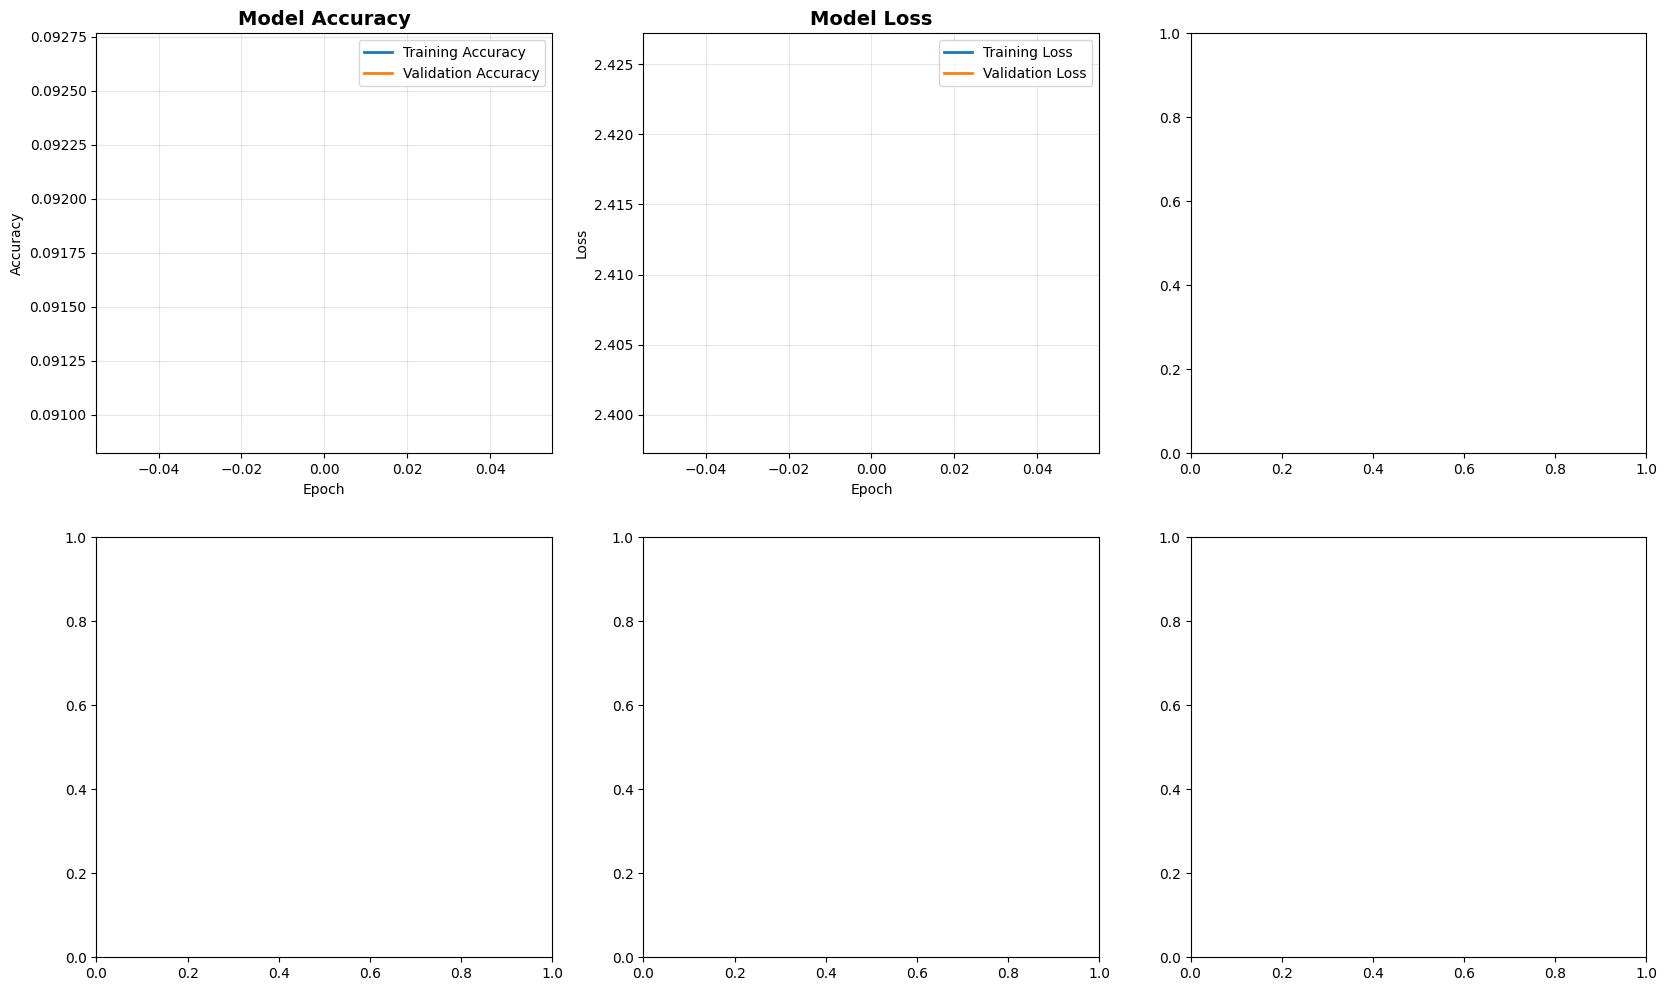

In [ ]:
def plot_comprehensive_results(history, model, test_generator, class_names):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. График точности
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. График потерь
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. График F1-score
    axes[0, 2].plot(history.history['f1_score'], label='Training F1-Score', linewidth=2)
    axes[0, 2].plot(history.history['val_f1_score'], label='Validation F1-Score', linewidth=2)
    axes[0, 2].set_title('Model F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1-Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Матрица ошибок на тестовых данных
    # Получаем предсказания для тестового набора
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Нормализованная матрица ошибок
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = axes[1, 0].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Test Set - Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=axes[1, 0])
    
    tick_marks = np.arange(len(class_names))
    axes[1, 0].set_xticks(tick_marks)
    axes[1, 0].set_yticks(tick_marks)
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].set_yticklabels(class_names)
    
    # Добавляем текстовые аннотации
    thresh = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            axes[1, 0].text(j, i, f'{cm_normalized[i, j]:.2f}',
                           ha="center", va="center",
                           color="white" if cm_normalized[i, j] > thresh else "black")
    
    # 5. F1-score по классам на тестовых данных
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred_classes, average=None
    )
    
    classes_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    x = range(len(class_names))
    axes[1, 1].bar(x, f1, color='skyblue', alpha=0.7)
    axes[1, 1].set_title('Test Set - F1-Score by Class', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for i, v in enumerate(f1):
        axes[1, 1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    # 6. Сравнение Precision и Recall на тестовых данных
    x = np.arange(len(class_names))
    width = 0.35
    
    axes[1, 2].bar(x - width/2, precision, width, label='Precision', alpha=0.7)
    axes[1, 2].bar(x + width/2, recall, width, label='Recall', alpha=0.7)
    axes[1, 2].set_title('Test Set - Precision vs Recall by Class', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Classes')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return classes_df, y_true, y_pred_classes

# Функция для отображения примеров классификации
def show_classification_examples(model, test_generator, class_names, num_examples=12):
    # Получаем батч данных
    x_batch, y_batch = next(test_generator)
    y_batch_classes = np.argmax(y_batch, axis=1)
    
    # Предсказания
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence = np.max(predictions, axis=1)
    
    # Отображаем примеры
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(min(num_examples, len(x_batch))):
        axes[i].imshow(x_batch[i])
        
        true_label = class_names[y_batch_classes[i]]
        pred_label = class_names[predicted_classes[i]]
        conf = confidence[i]
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Оценка модели на тестовых данных
print("\nОценка на тестовых данных:")
test_loss, test_accuracy, test_f1 = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Расширенная визуализация результатов
classes_df, y_true, y_pred_classes = plot_comprehensive_results(
    history, model, test_generator, class_names
)


ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ НА ТЕСТОВЫХ ДАННЫХ

Classification Report:
               precision    recall  f1-score   support

    apple_pie       0.00      0.00      0.00       100
   cheesecake       0.09      1.00      0.17       100
chicken_curry       0.00      0.00      0.00       100
 french_fries       0.00      0.00      0.00       100
   fried_rice       0.00      0.00      0.00       100
    hamburger       0.00      0.00      0.00       100
      hot_dog       0.00      0.00      0.00       100
    ice_cream       0.00      0.00      0.00       100
     omelette       0.00      0.00      0.00       100
        pizza       0.00      0.00      0.00       100
        sushi       0.00      0.00      0.00       100

     accuracy                           0.09      1100
    macro avg       0.01      0.09      0.02      1100
 weighted avg       0.01      0.09      0.02      1100


F1-Score по классам:
            Class  Precision  Recall  F1-Score  Support
0       apple_pie

C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


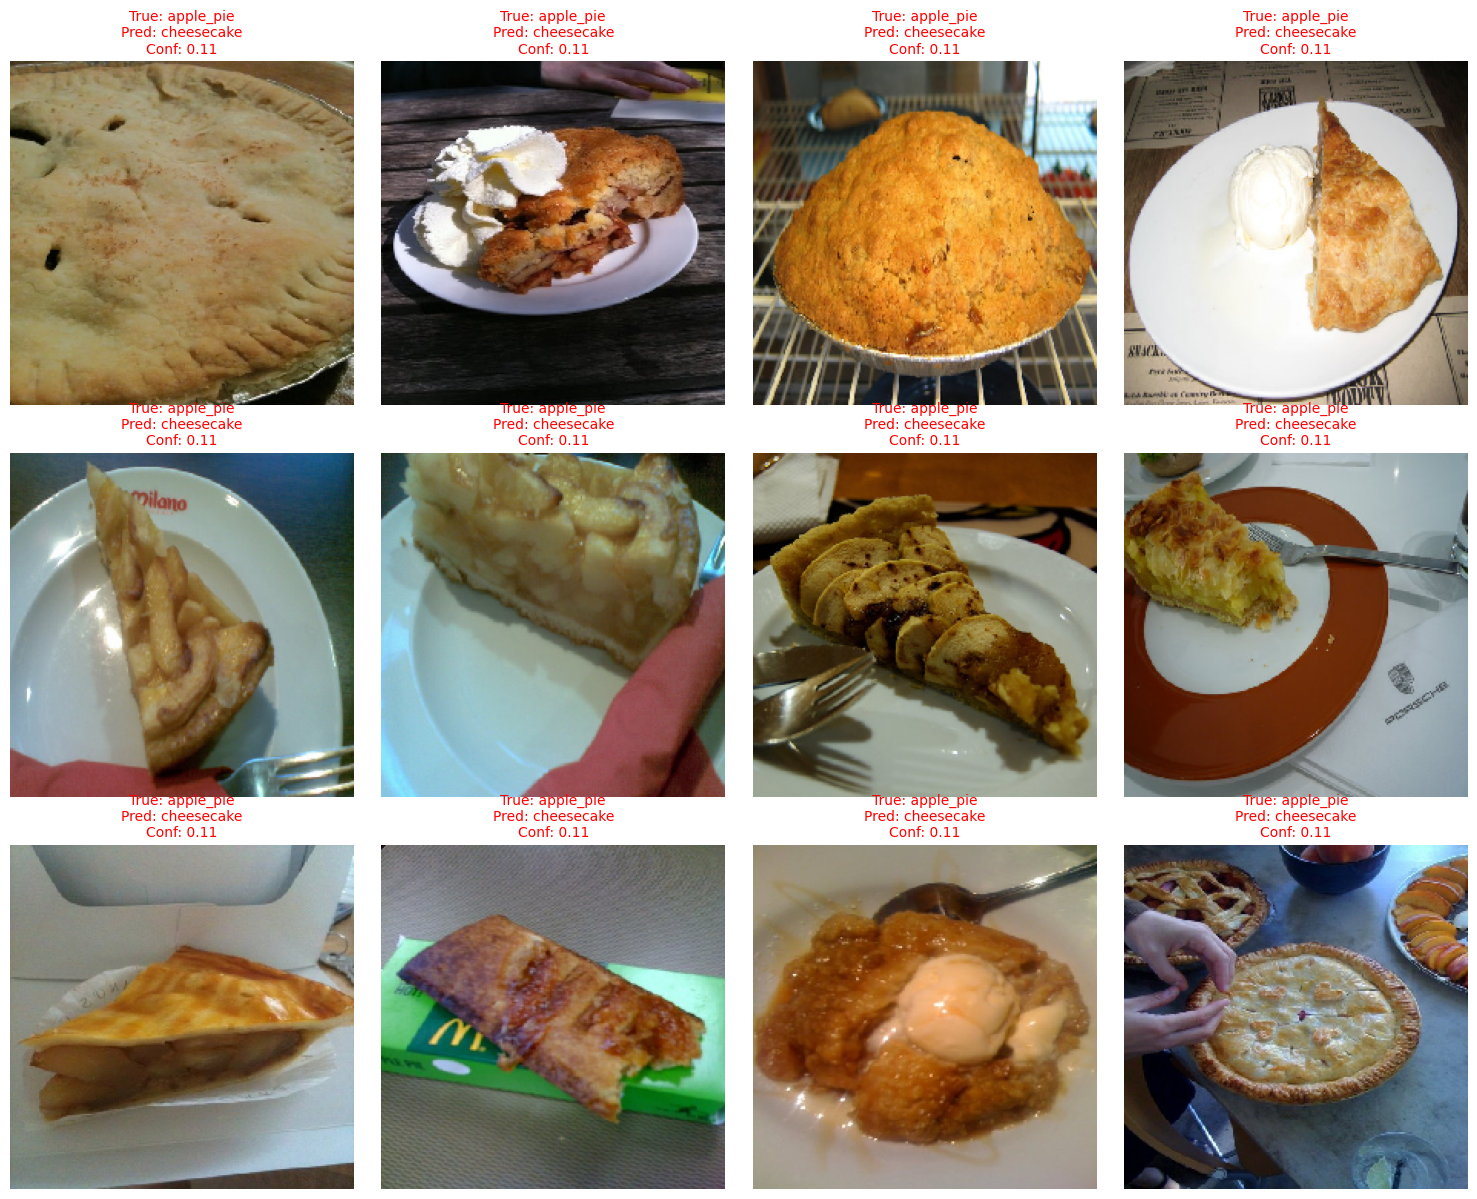


Отображение топ ошибок классификации на тестовых данных...
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step


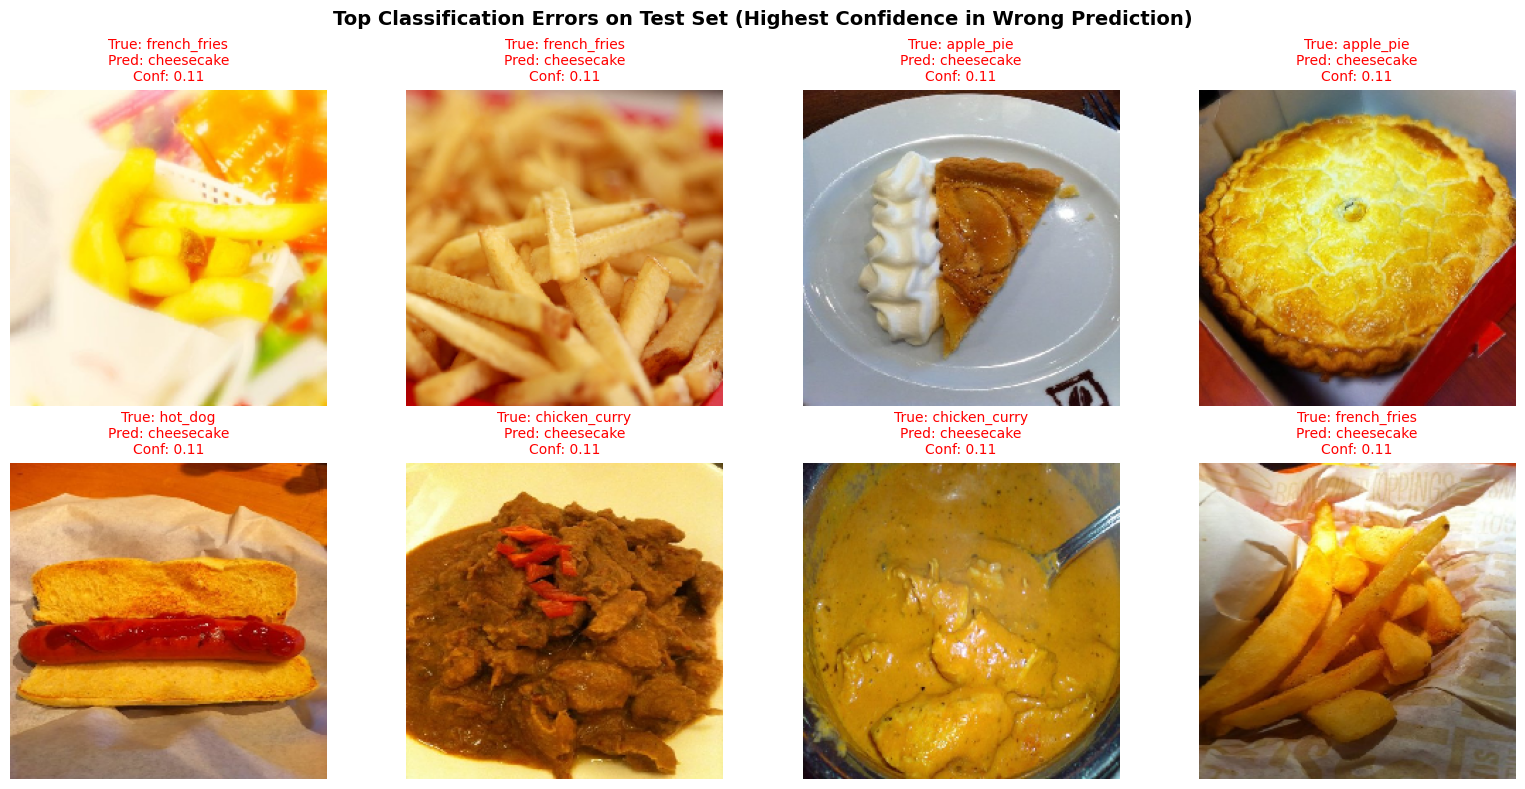


Модель сохранена как 'food11_efficientnet_final.h5'
Результаты сохранены в 'model_results.csv'


In [ ]:
print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

print("\nF1-Score по классам:")
print(classes_df.round(3))

# Общая статистика
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nОбщие метрики на тестовых данных:")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Отображение примеров классификации
print("\nОтображение примеров классификации на тестовых данных...")
show_classification_examples(model, test_generator, class_names)

# Дополнительная визуализация - топ ошибок классификации
def plot_top_errors(model, test_generator, class_names, top_k=8):
    # Получаем все предсказания
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Находим примеры с наибольшей ошибкой
    errors = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred_classes[i]:
            confidence = np.max(y_pred[i])
            errors.append((i, y_true[i], y_pred_classes[i], confidence))
    
    # Сортируем по уверенности в неправильном предсказании
    errors.sort(key=lambda x: x[3], reverse=True)
    
    # Берем топ ошибок
    top_errors = errors[:top_k]
    
    # Отображаем
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    test_generator.reset()
    all_images = []
    all_labels = []
    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        all_images.extend(x_batch)
        all_labels.extend(np.argmax(y_batch, axis=1))
        if len(all_images) >= len(y_true):
            break
    
    for idx, (error_idx, true_class, pred_class, conf) in enumerate(top_errors):
        if error_idx < len(all_images):
            axes[idx].imshow(all_images[error_idx])
            true_label = class_names[true_class]
            pred_label = class_names[pred_class]
            axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}', 
                              color='red', fontsize=10)
            axes[idx].axis('off')
    
    plt.suptitle('Top Classification Errors on Test Set (Highest Confidence in Wrong Prediction)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Отображение топ ошибок
print("\nОтображение топ ошибок классификации на тестовых данных...")
plot_top_errors(model, test_generator, class_names)

# Сохранение финальной модели
model.save('food11_efficientnet_final.h5')
print("\nМодель сохранена как 'food11_efficientnet_final.h5'")

# Сохранение результатов в файл
results_df = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test Loss', 'Test F1-Score', 'Macro F1-Score', 'Weighted F1-Score'],
    'Value': [test_accuracy, test_loss, test_f1, macro_f1, weighted_f1]
})
results_df.to_csv('model_results.csv', index=False)
print("Результаты сохранены в 'model_results.csv'")